# 1. Data Preprocessing
## Basic imports

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import sys
sys.path.insert(1, '../..')
from imports.methods import plot_decision_regions

## 1. Identifying missing values in tabular data
- It is sometimes more convenient to preprocess data using pandas DataFrame instead of a numpy array (initially scipy only supported numpy arrays as inputs)
- We can read Comma-separated values (CSV) formatted data into a pandas library DataFrame
- StringIO allows us to read a string as if it was a regular CSV file on a hard drive

In [39]:
import pandas as pd
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# If you are using Python 2.7, you need
# to convert the string to unicode:

if (sys.version_info < (3, 0)):
    csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


## 2. Finding the number of missing values per column

In [40]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

## 3. Accesing the undelying numpy array of a DataFrame

In [41]:
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

# 2. Eliminating training examples or features with missing values
## 1. Remove rows that contain missing values

In [42]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


## 2. Remove columns that contain missing values

In [43]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


## 3. Only drop rows where all columns are NaN

In [44]:
df.dropna(how='all')  

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


## 4. Drop rows that have fewer than 3 real values 

In [45]:
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


## 5. Only drop rows where NaN appear in specific columns (here: 'C')

In [46]:
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


# 3. Imputing missing values
- We can use many interpolation techniques to estimate the missing values from other training examples in our dataset
## 1. Impute missing values via the column mean (using scikit SimpleImputer)

In [47]:
from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

###2. Impute missing values via the column mean (using pandas' fillna method)

In [48]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


# 4. Handling categorical data
## 1. Nominal and ordinal features
- We can define order on ordinal features (so they can be sorted and ordered), but nominal features do not imply any order at all

In [49]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


## 2. Mapping ordinal features
- In most cases there is no convenient function to derive correct order of the labels of an ordinal feature, so we have define mapping manually

In [50]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


## 3. Inverse mapping ordinal features

In [51]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

## 4.1. Encoding class labels
- Create a mapping dictionary to convert class labels from strings to integers

In [52]:
# create a mapping dict
# to convert class labels from strings to integers
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [53]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


## 4.2. Reversing class label mapping

In [54]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


## 5.1. Encoding class labels using LabelEncoder

In [55]:
from sklearn.preprocessing import LabelEncoder

# Label encoding with sklearn's LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

## 5.2. Reversing class label mapping using LabelEncoder

In [56]:
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

# 5. Performing one-hot encoding on nominal features
- It might seem like encoding nominal features using enumeration without any concern about ordering is a good idea, since we do not care about the order
- The issue is that if we blindly assign different integers to different labels we will introduce ordering, which will make a lerning algorithm assume that, in this case, "green" is larger than "blue", etc.
- The results of the algorithm will not be optimal and might not be useful at all
## 1. Incorrect approach
- blue = 0
- green = 1
- red = 2

In [57]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

## 2. One-hot encoding approach
- The idea behind this approach is to introduce a new dummy feature for each unique value in the nominal feature column

In [58]:
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

## 3. Transforming columns selectively using ColumnTransformer

In [59]:
from sklearn.compose import ColumnTransformer

X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(), [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

## 4. Creating dummy features using pd.get_dummies()

In [60]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


- Using one-hot encodings introduces multicollinearity (high correlation between features), which can be an issue for certain methods (ones requiring matrix inversion)
- Removing one of the newly-created dummy features helps reduce the effects of that without any information loss

In [61]:
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


## 5. Removing the redundant column via OneHotEncoder

In [62]:
color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([ ('onehot', color_ohe, [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

# 6. Partitioning a dataset into separate training and test datasets
## 1. Loading the Wine dataset

In [63]:
df_wine = pd.read_csv('data/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## 2. Partitioning the dataset into separate test and training datasets

In [64]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

## 3. Bringing features onto the same scale
- If 2 features are on 2 different scales, for example on the scales from 1 to 10 and from 1 to 100000, the algorithmic changes to the weights will be mostly based on the contributions of the second feature to the error function output value (for example squared error function)
- Another exmaple is KNN algorithm, where computed distances will be dominated by the second feature axis
- Decision tress and random forests are two of the very few machine learning algorithms that do not require feature scaling

- Normalization refers to rescaling of the features to a range of `[0, 1]`, which is a special case of min-max scaling

In [65]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

- Although normalization is a commonly used technique that is useful when we need values in a bounded interval, standardization can be more practical for many machine learning algorithms, especially for optimization algorithms such as gradient descent // book quote
- The reason is that many linear models, such as logistic regression and SVM initialize the weights to 0 or small random values close to 0. Using standardization, we center the feature columns at mean 0 with standard deviation 1 so that the feature columns have the same parameters as a standard normal distribution (zero mean and unit variance), which makes it easier to learn the weights // book quote
- Standardization maintains useful information about outliers and make the algorith less sensitive to them in contrast to min-max scaling

In [66]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## 4. Visual example of both scalings

In [67]:
ex = np.array([0, 1, 2, 3, 4, 5])

print('standardized:', (ex - ex.mean()) / ex.std())

# Please note that pandas uses ddof=1 (sample standard deviation) 
# by default, whereas NumPy's std method and the StandardScaler
# uses ddof=0 (population standard deviation)

# normalize
print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
normalized: [0.  0.2 0.4 0.6 0.8 1. ]


# 7. Selecting meaningful features
## 1. L1 and L2 regularization as penalties against model complexity
- L2 regularization is one approach to reduce the complexity of a model by penalizing large individual weights
- In contrast to L2 regularization, L1 regularization usually yields sparse feature vectors (most values in a vector are zero) and most feature weigts will be zero
- Sparsity can be useful if we have a dataset with many irrelevant features, in this sense L1 regularization can be undestood as a technique for feature selection

## 2. Regularized models in scikit-learn
- For regularized models in scikit-learn that support L1 regularization, we can simply set the `penalty` parameter to `'l1'` to obtain a sparse solution:

In [68]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## 3. Training regularized models on the Wine dataset

In [69]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
# Note that C=1.0 is the default. You can increase
# or decrease it to make the regulariztion effect
# stronger or weaker, respectively.
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


### 1. Accessing the intercept terms via intercept_ attribute
- intercept_ corresponds to w0 (the bias)
- Since we fit the Logistic regression object on a multiclass dataset via the one-vs-rest (OvR) approach, the first intercept belongs to the model that fits class 1 versus classes 2 and 3, etc.

In [70]:
lr.intercept_

array([-1.26365714, -1.21595236, -2.37051513])

### 2. Accessing the weights (w1+) via coef_

In [71]:
lr.coef_

array([[ 1.24602749,  0.18043199,  0.74576859, -1.16350928,  0.        ,
         0.        ,  1.15976134,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55665477,  2.50902954],
       [-1.53742027, -0.38698468, -0.99573873,  0.36496965, -0.05923206,
         0.        ,  0.6681944 ,  0.        ,  0.        , -1.93401777,
         1.23346005,  0.        , -2.23140687],
       [ 0.13564449,  0.16861467,  0.35710121,  0.        ,  0.        ,
         0.        , -2.43786083,  0.        ,  0.        ,  1.56372411,
        -0.8184007 , -0.4926932 ,  0.        ]])

## 4. Observing the influence of L1 regularization strength on the weight coefficients
- As we can see, all weights converge towards zero if we penalize the mdoel with a strong regularization parameter (C being the inverse of it)

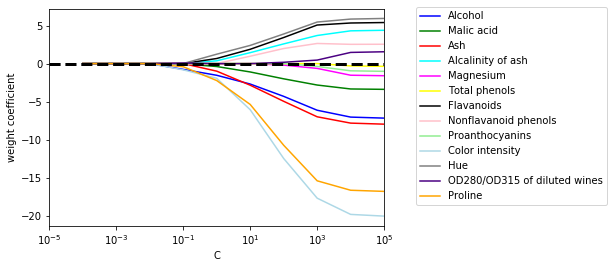

In [72]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear', 
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

# 8. Sequential feature selection algorithms
## 1. Sequential backward selection (SBS) algorithm implementation
- The algorithm removes one feature on each iteration of the while loop based on the effect of its removal on perfomance of the classifier

In [73]:
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

## 2. Comparing performances of the classifier with different number of features (reduced by SBS)

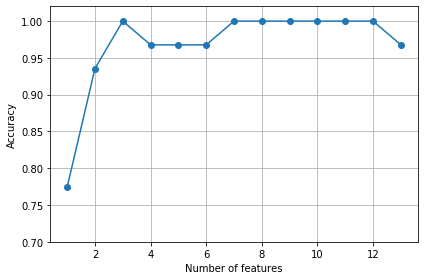

In [74]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

## 3. Observing which features are in the smallest most-accurate feature subset (k=3)

In [75]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


## 4. Comparing performances of classifiers with the full and a significantly reduced feature sets
### 1. Full feature set performance

In [76]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


### 2. 3-feature subset (selected by the SBS algorithm) performance

In [77]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


# 9. Assessing feature importance with Random Forests
- Using a random forest, we can measure the feature importance as the averaged impurity decrease computed from all decision trees in the forest, without making any assumption about whether our data is linearly separable or not // book quote
- Scikit-learn implementation conveniently does that for us already
## 1. Plotting results for a forest with 500 tress
- Two of the top-ranked features in the plot are also in the three-feature subset selection from the SBS algorithm (a)

1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


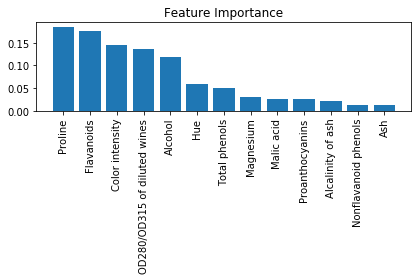

In [78]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

## 2. Using SelectFromModel object to select features based on a given model and a selected threshold
- By setting the threshold to 0.1 we select the most important 5 features based on the influence on purity in the random forest model

In [80]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])

Number of features that meet this threshold criterion: 5


In [81]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
